In [74]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

# Methods from solution reference
def tailMetrics(returns, quantile=.05, relative=False, mdd=True):
    
    #Maximum Drawdown
    def maximumDrawdown(returns):
        cum_returns = (1 + returns).cumprod()
        rolling_max = cum_returns.cummax()
        drawdown = (cum_returns - rolling_max) / rolling_max

        max_drawdown = drawdown.min()
        end_date = drawdown.idxmin()
        summary = pd.DataFrame({'Max Drawdown': max_drawdown, 'Bottom': end_date})

        for col in drawdown:
            summary.loc[col,'Peak'] = (rolling_max.loc[:end_date[col],col]).idxmax()
            recovery = (drawdown.loc[end_date[col]:,col])
            try:
                summary.loc[col,'Recover'] = pd.to_datetime(recovery[recovery >= 0].index[0])
            except:
                summary.loc[col,'Recover'] = pd.to_datetime(None)

            summary['Peak'] = pd.to_datetime(summary['Peak'])
            try:
                summary['Duration (to Recover)'] = (summary['Recover'] - summary['Peak'])
            except:
                summary['Duration (to Recover)'] = None

            summary = summary[['Max Drawdown','Peak','Bottom','Recover','Duration (to Recover)']]

        return summary  
    
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Skewness'] = returns.skew()
    metrics['Kurtosis'] = returns.kurtosis()

    VaR = returns.quantile(quantile)
    CVaR = (returns[returns < returns.quantile(quantile)]).mean()

    if relative:
        VaR = (VaR - returns.mean())/returns.std()
        CVaR = (CVaR - returns.mean())/returns.std()

    metrics[f'VaR ({quantile})'] = VaR
    metrics[f'CVaR ({quantile})'] = CVaR

    if mdd:
        mdd_stats = maximumDrawdown(returns)
        metrics = metrics.join(mdd_stats)

        if relative:
            metrics['Max Drawdown'] = (metrics['Max Drawdown'] - returns.mean())/returns.std()

    return metrics


def get_ols_metrics(regressors, targets, annualization=1, ignorenan=True):
    # ensure regressors and targets are pandas dataframes, as expected
    if not isinstance(regressors, pd.DataFrame):
        regressors = regressors.to_frame()
    if not isinstance(targets, pd.DataFrame):
        targets = targets.to_frame()

    # align the targets and regressors on the same dates
    df_aligned = targets.join(regressors, how='inner', lsuffix='y ')
    Y = df_aligned[targets.columns]
    Xset = df_aligned[regressors.columns]

    reg = pd.DataFrame(index=targets.columns)
    for col in Y.columns:
        y = Y[col]
        
        if ignorenan:
            # ensure we use only non-NaN dates
            alldata = Xset.join(y,lsuffix='X')
            mask = alldata.notnull().all(axis=1)
            y = y[mask]
            X = Xset[mask]
        else:
            X = Xset

        model = LinearRegression().fit(X, y)
        reg.loc[col, 'alpha'] = model.intercept_ * annualization
        reg.loc[col, regressors.columns] = model.coef_
        reg.loc[col, 'r-squared'] = model.score(X, y)

        # sklearn does not return the residuals, so we need to build them
        yfit = model.predict(X)
        residuals = y - yfit

        # Treynor Ratio is only defined for univariate regression
        if Xset.shape[1] == 1:
            reg.loc[col,'Treynor Ratio'] = (y.mean() / model.coef_) * annualization

        
        # if intercept =0, numerical roundoff will nonetheless show nonzero Info Ratio
        num_roundoff = 1e-12
        if np.abs(model.intercept_) < num_roundoff:
            reg.loc[col, 'Info Ratio'] = None
        else:
            reg.loc[col, 'Info Ratio'] = (model.intercept_ / residuals.std()) * np.sqrt(annualization)

    return reg

## 2 Pricing Factors and Analysis
### 1. The Factors: • mean • volatility • Sharpe • VaR(.05)

In [82]:
# Get data from spreadsheet
data = pd.read_excel('../data/factor_pricing_data.xlsx', sheet_name = 'factors (excess)').set_index('Date')

# Annualized Mean, Volatility, Sharpe Ratio, and VaR (Value-at-Risk)
factors = data.describe().loc[['mean','std']].transpose()
factors['Annual_Mean'] = factors['mean'] * 12
factors['Annual_Std'] = factors['std'] * (12**0.5)
factors['Sharpe Ratio'] = factors['Annual_Mean']/factors['Annual_Std']
# factors['VaR'] = factors['']
tail_metrics = tailMetrics(data)
factors['VaR (0.05)'] = tail_metrics['VaR (0.05)']
factors[['Annual_Mean','Annual_Std','Sharpe Ratio','VaR (0.05)']]

,Annual_Mean,Annual_Std,Sharpe Ratio,VaR (0.05)
MKT,0.082,0.154,0.533,-0.079
SMB,0.011,0.109,0.103,-0.043
HML,0.014,0.114,0.124,-0.042
UMD,0.054,0.164,0.328,-0.073


Each factor has a risk premium (positive expected excess return) as seen in Annual_Mean

### 2. Correlation Matrix

Factors with highest correlation: ('MKT', 'UMD')
Factors with lowest correlation: ('UMD', 'SMB')


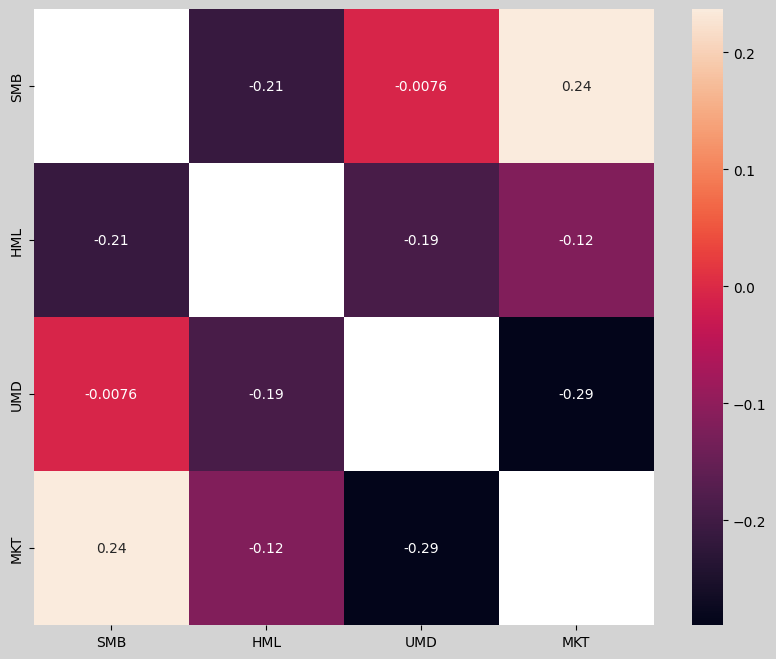

In [76]:
corrmat = data[['SMB','HML','UMD', 'MKT']].corr()
corrmat[corrmat==1] = None
corr_rank = abs(corrmat.unstack()).sort_values(ascending = False).dropna()
print('Factors with highest correlation: ' + str(corr_rank.index[1]))
print('Factors with lowest correlation: ' + str(corr_rank.index[-1]))
plt.figure(figsize=(10,8),facecolor='lightgray')
sns.heatmap(corrmat, annot=True)
plt.show()


### 3. Plot cumulative returns of factors

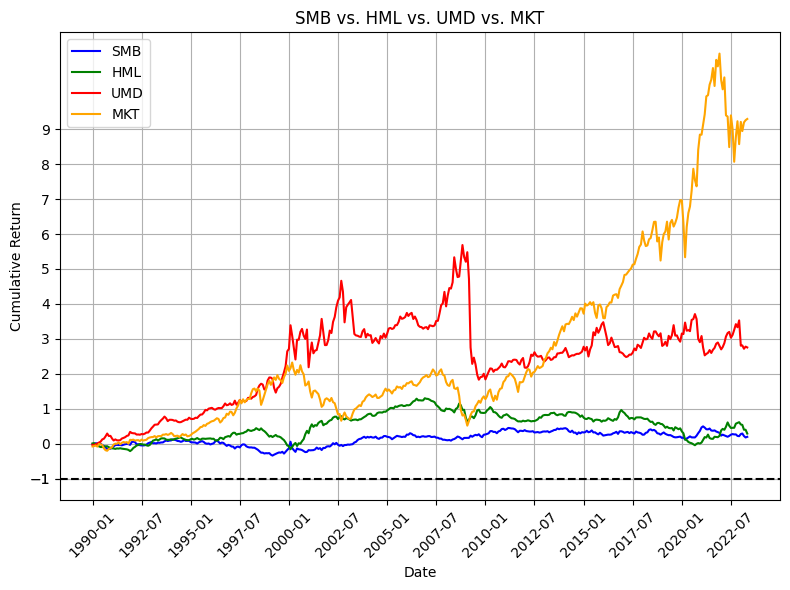

In [77]:
# Plot cumulative returns
fac_df = {
    "SMB": (1 + data["SMB"]).cumprod() - 1,
    "HML": (1 + data["HML"]).cumprod() - 1,
    "UMD": (1 + data["UMD"]).cumprod() - 1,
    "MKT": (1 + data["MKT"]).cumprod() - 1,
}

fac_df = pd.DataFrame(fac_df, index=data["SMB"].index)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(fac_df.index, fac_df["SMB"], label="SMB", color="blue")
ax.plot(fac_df.index, fac_df["HML"], label="HML", color="green")
ax.plot(fac_df.index, fac_df["UMD"], label="UMD", color="red")
ax.plot(fac_df.index, fac_df["MKT"], label="MKT", color="orange")


ax.legend()
ax.grid(True)

ax.axhline(-1, color="black", linestyle="--")

ax.set_xticks(fac_df.index[::30])
ax.set_xticklabels(
    [f"{i.year}-{i.month:02d}" for i in fac_df.index[::30]],
    rotation=45,
    horizontalalignment="center",
)
ax.set_title("SMB vs. HML vs. UMD vs. MKT")
ax.set_yticks([-1] + [i for i in range(-1, 10, 1)])
ax.set_ylabel("Cumulative Return")
ax.set_xlabel("Date")
fig.tight_layout()

### 4. Test Assets

In [84]:
# Get asset data from spreadsheet
asset = pd.read_excel('../data/factor_pricing_data.xlsx', sheet_name = 'assets (excess)').set_index('Date')

# Annualized Mean, Volatility, Sharpe Ratio, and VaR (Value-at-Risk)
asset_stats = asset.describe().loc[['mean','std']].transpose()
asset_stats['Annual_Mean'] = asset_stats['mean'] * 12
asset_stats['Annual_Std'] = asset_stats['std'] * (12**0.5)
asset_stats['Sharpe Ratio'] = asset_stats['Annual_Mean']/asset_stats['Annual_Std']
tail_metrics_assets = tailMetrics(asset)
asset_stats['VaR (0.05)'] = tail_metrics_assets['VaR (0.05)']
asset_stats['r_i'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
asset_stats[['r_i','Annual_Mean','Annual_Std','Sharpe Ratio','VaR (0.05)']]

,r_i,Annual_Mean,Annual_Std,Sharpe Ratio,VaR (0.05)
NoDur,1,0.082,0.133,0.614,-0.058
Durbl,2,0.098,0.283,0.347,-0.116
Manuf,3,0.098,0.188,0.523,-0.087
Enrgy,4,0.087,0.226,0.385,-0.099
Chems,5,0.079,0.150,0.527,-0.075
BusEq,6,0.124,0.236,0.527,-0.111
Telcm,7,0.049,0.179,0.272,-0.092
Utils,8,0.070,0.140,0.500,-0.064
Shops,9,0.094,0.163,0.573,-0.077
Hlth,10,0.094,0.153,0.616,-0.071


### 5. Can the difference in mean excess returns of the portfolios be explained by differences in their volatilities? Or by their VaR(.05) statistics?

Neither, mean excess return does not have a strong correlation with either volatility or VaR. Thus, we cannot conclusively say mean excess return is explained by volatility or VaR(.05).

In [85]:
corrmat = asset_stats[['Annual_Mean','Annual_Std', 'VaR (0.05)']].corr()
corrmat

,Annual_Mean,Annual_Std,VaR (0.05)
Annual_Mean,1.000,0.467,-0.409
Annual_Std,0.467,1.000,-0.963
VaR (0.05),-0.409,-0.963,1.000


## 3 CAPM
### 1. For each of the n = 12 test assets, run the CAPM time-series regression

In [86]:
capm_ts = get_ols_metrics(data['MKT'], asset, annualization=12, ignorenan=True)

### 2. Estimated βi,mkt, Treynor Ratio, αi, and Information Ratio for each of the n regressions

In [96]:
display(capm_ts.style.format(formatter = {'alpha' : '{:,.2%}', 'MKT' : '{:,.2f}', 'r-squared' : '{:,.2%}',\
                             'Treynor Ratio' : '{:,.2f}', 'Info Ratio' : '{:,.2f}'}))

,alpha,MKT,r-squared,Treynor Ratio,Info Ratio
NoDur,2.99%,0.63,53.42%,0.13,0.33
Durbl,-1.41%,1.37,55.57%,0.07,-0.07
Manuf,0.74%,1.11,82.49%,0.09,0.09
Enrgy,1.62%,0.87,34.68%,0.10,0.09
Chems,1.63%,0.77,61.95%,0.10,0.18
BusEq,1.58%,1.32,74.45%,0.09,0.13
Telcm,-2.73%,0.93,63.33%,0.05,-0.25
Utils,3.54%,0.43,21.71%,0.17,0.29
Shops,1.95%,0.90,72.51%,0.10,0.23
Hlth,3.64%,0.71,50.39%,0.13,0.34


### 3. If (CAPM) were true, what would be true of the Treynor Ratios, alphas, and Information Ratios?

If the CAPM is were true, we would expect the Treynor Ratio to be the same for all assets (as they would have no idiosyncratic risks), alphas to be zero, and information ratios to be zero.

### 4. Calculate the mean-absolute-error of the estimated alphas, (one for each security,  ̃r_i.)

In [95]:
mean_absolute_error = capm_ts.alpha.abs().mean()
mean_absolute_error_percent = '{:,.2%}'.format(mean_absolute_error)
print(f'Mean absolute error from CAPM: {mean_absolute_error} or {mean_absolute_error_percent}')

Mean absolute error from CAPM: 0.020559543899219403 or 2.06%


## 4 Multifactor Model

### 1. For each regression, report the estimated α and r-squared.

In [100]:
mfm_ts = get_ols_metrics(data, asset, annualization=12, ignorenan=True)
display(mfm_ts.style.format(formatter = 
                              {
                                  'alpha' : '{:,.2%}',
                                  'r-squared' : '{:,.2%}',
                                  'MKT' : '{:,.2f}',
                                  'SMB' : '{:,.2f}',
                                  'HML' : '{:,.2f}',
                                  'UMD' : '{:,.2f}',
                                  'Info Ratio' : '{:,.2f}'
                              }
                            )
                          )

,alpha,MKT,SMB,HML,UMD,r-squared,Info Ratio
NoDur,2.34%,0.70,-0.23,0.19,0.03,60.17%,0.28
Durbl,0.78%,1.24,0.28,0.25,-0.33,61.28%,0.04
Manuf,0.69%,1.10,0.10,0.28,-0.07,86.00%,0.10
Enrgy,-0.16%,0.92,0.09,0.72,0.04,46.83%,-0.01
Chems,1.17%,0.82,-0.18,0.22,-0.01,67.24%,0.14
BusEq,3.77%,1.21,0.17,-0.63,-0.10,84.48%,0.41
Telcm,-2.43%,0.94,-0.15,0.02,-0.05,64.49%,-0.23
Utils,1.91%,0.53,-0.24,0.30,0.12,32.44%,0.17
Shops,2.24%,0.90,-0.03,-0.03,-0.03,72.64%,0.26
Hlth,3.15%,0.76,-0.20,-0.12,0.09,53.58%,0.30


In [101]:
print('Mean-Absolute-Error: {:,.2%}'.format(mfm_ts.alpha.abs().mean()))

Mean-Absolute-Error: 1.86%
